- title: Inverse RL
- summary: step by step tutorial about Apprenticeship Learning using Inverse Reinforcement Learning
- author: Silvia TULLI
- feedback and revision: Kim BARAKA, Mohamed CHETOUANI, Muhan HOU
- teaching assistant: Márton Bodó, Fabiano Busca
- date: 2026-February-March

This notebook contains an excerpt from the **Human-Interactive Robot Learning (HIRL)** educational module.\
For more information check out [our website](https://sites.google.com/view/hirl-education?usp=sharing).


# **Goals**
* Implement Apprenticeship Learning Algorithm
* Apply Apprenticeship Learning to simple tasks.
* Implement Maximum Conditional Entropy Inverse Reinforcement Learning (MCE-IRL)

# **Apprenticeship Learning using Inverse Reinforcement Learning**
Apprenticeship Learning is an approach that involves **learning how to perform tasks by observing an expert**. Inverse Reinforcement Learning (IRL) is a specific technique used to **infer the reward function governing an expert’s behavior** based on their observed actions in different states.


## **Inverse Reinforcement Learning vs Behavioral Cloning**

Unlike Behavioural Cloning, which directly maps observed states to actions through straightforward supervised learning methods, Inverse Reinforcement Learning (IRL) in Apprenticeship Learning delves into inferring the reward functions that underpin expert behaviours. This approach not only seeks to replicate actions but also to **understand and embody the deeper motivations and goals of the expert**. Consequently, this leads to **greater adaptability and the ability to generalise to new situations**, which Behavioural Cloning often lacks due to its more rigid, data-dependent learning structure.

# **Environment Setup**
In this tutorial we will demonstrate how to solve the CartPole environment from OpenAI Gym using the Inverse Reinforcement Learning. We refer to the implementation described in the paper [Apprenticeship Learning via Inverse Reinforcement Learning](https://ai.stanford.edu/~ang/papers/icml04-apprentice.pdf). For the sole purpose of demonstration, the expert trajectories are extrapolated from a Q-learning agent, with discretized observable state space. The IRL algorithm learns from these trajectories.

In [1]:
!pip install stable-baselines3[extra]
!pip install seals stable-baselines3[extra] imitation
# on macOs quotation marks are required
# !pip install 'stable-baselines3[extra]'
# !pip install seals 'stable-baselines3[extra]' imitation

zsh:1: no matches found: stable-baselines3[extra]
zsh:1: no matches found: stable-baselines3[extra]


# **Load Environment**
![CartPole](https://www.gymlibrary.dev/_images/cart_pole.gif)

```
Action Space: Discrete(2)
Observation Space:
Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38],
    [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
```

For more information about the environment, let's check out the CartPole environment in the documentation: [CartPole](https://github.com/openai/gym/blob/master/gym/envs/classic_control/cartpole.py)



In [2]:
import gymnasium as gym
import numpy as np
from numpy.linalg import norm
import matplotlib.pyplot as plt
from IPython.display import clear_output
import pickle
import time
import sys
import math
import seaborn as sns
from functools import partial
from seals import base_envs
from seals.diagnostics.cliff_world import CliffWorldEnv
from stable_baselines3.common.vec_env import DummyVecEnv
import numpy as np

from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
from imitation.data import rollout
from imitation.rewards import reward_nets
import matplotlib.pyplot as plt
import torch as th
from typing import Dict, Tuple, Any, List, Optional, Union

In [3]:
env_name = 'CartPole-v1'
env = gym.make(env_name)

nbins = 10
GAMMA = 0.9
ALPHA = 0.01

# **Generate Expert Trajectories from Q-learning Expert**
We define a **Q-learning agent** to compute a policy for this environment, and then extract the expert trajectories based on that policy.




In [4]:
def max_dict(d: Dict[Any, float]) -> Tuple[Any, float]:
    """
    looking for the action that gives the maximum value for a given state
    """
    max_v = float('-inf')
    for key, val in d.items():
        if val > max_v:
            max_v = val
            max_key = key
    return max_key, max_v

In [5]:
def create_bins() -> np.ndarray:
    """
    create bins to discretize the continuous observable state space
    """
    # obs[0] -> cart position --- -4.8 - 4.8
    # obs[1] -> cart velocity --- -inf - inf
    # obs[2] -> pole angle    --- -41.8 - 41.8
    # obs[3] -> pole velocity --- -inf - inf

    bins = np.zeros((4,nbins))
    bins[0] = np.linspace(-4.8, 4.8, nbins)
    bins[1] = np.linspace(-5, 5, nbins)
    bins[2] = np.linspace(-.418, .418, nbins)
    bins[3] = np.linspace(-5, 5, nbins)
    return bins

In [6]:
def assign_bins(observation: np.ndarray, bins: np.ndarray) -> np.ndarray:
    """
    discretizing the continuous observation space into state
    """
    state = np.zeros(4)
    for i in range(4):
        state[i] = np.digitize(observation[i], bins[i])
    return state

In [7]:
def get_state_as_string(state: np.ndarray) -> str:
    """
    encoding the state into string as dictionary
    """
    string_state=''
    for e in state:
            string_state = string_state+str(int(e)).zfill(2)
    return string_state

In [8]:
def get_all_states_as_string() -> List[str]:
    states = []
    for i in range (nbins+1):
        for j in range (nbins+1):
            for k in range(nbins+1):
                for l in range(nbins+1):
                    a=str(i).zfill(2)+str(j).zfill(2)+str(k).zfill(2)+str(l).zfill(2)
                    states.append(a)
    return states

In [9]:
def initialize_Q() -> Dict[str, Dict[int, float]]:
    """
    initialize your Q table
    """
    Q = {}

    all_states = get_all_states_as_string()
    for state in all_states:
        Q[state] = {}
        for action in range(env.action_space.n):
            Q[state][action] = 0
    return Q

## **Question 1**
1. Fill in the blank space with your code to update the Q-table. The value of $\alpha$ and $γ$ are already assigned to the variables named ALPHA and GAMMA.


In [10]:
def play_one_game(bins: np.ndarray, Q: Dict[str, Dict[int, float]], eps: float = 0.5) -> Tuple[float, int]:
    """
    train 1 episode
    """
    observation, _ = env.reset()
    terminated = False
    truncated = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0

    while not (terminated or truncated):
        cnt += 1

        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]
        observation, reward, terminated, truncated, info  = env.step(act)

        total_reward += reward

        if (terminated or truncated) and cnt < 200:
            reward = -300

        state_new = get_state_as_string(assign_bins(observation, bins))

        a1, max_q_s1a1 = max_dict(Q[state_new])

        # update the Q-table for Q(s_t, a_t)
        ''' Add your code here '''
        Q[state][act] = Q[state][act] + ALPHA * (reward + GAMMA * max_q_s1a1 - Q[state][act])


        state, act = state_new, a1

    return total_reward, cnt

In [11]:
def play_many_games(bins: np.ndarray, N: int = 10000) -> Tuple[List[int], List[float], Dict[str, Dict[int, float]]]:
    """
    train many episodes
    """
    Q = initialize_Q()

    length = []
    reward = []
    for n in range(N):
        #eps=0.5/(1+n*10e-3)
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= play_one_game(bins, Q, eps)

        if n % 100 == 0:
            clear_output(wait=True)
            print("Episode: %d, Epislon: %.4f, Reward %d"%(n,eps,episode_reward))
        length.append(episode_length)
        reward.append(episode_reward)
    env.close()
    return length, reward, Q

In [12]:
def plot_running_avg(totalrewards: List[float], title: str = 'Running Average', save: bool = False, name: str = 'result') -> None:
    """
    plotting the average reward during training
    """
    fig=plt.figure()
    N = len(totalrewards)
    running_avg = np.empty(N)
    for t in range(N):
        running_avg[t] = np.mean(totalrewards[max(0, t-100):(t+1)])
    plt.plot(running_avg)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Duration")
#     plt.grid()
    if save:
        plt.savefig(name+'.png',bbox_inches='tight')
    else:
        plt.show()

In [13]:
def plot_running_avg_std(totalrewards: List[float], title: str = 'Running Average and Standard Deviation', save: bool = False, name: str = 'result') -> None:
    """
    Plotting the average and standard deviation of reward during training.
    """
    fig = plt.figure()
    N = len(totalrewards)
    running_avg = np.empty(N)
    running_std = np.empty(N)
    for t in range(N):
        window = totalrewards[max(0, t-100):(t+1)]
        running_avg[t] = np.mean(window)
        running_std[t] = np.std(window)
    plt.plot(running_avg, label='Running Average')
    plt.fill_between(range(N), running_avg - running_std, running_avg + running_std, color='b', alpha=0.2)
    plt.title(title)
    plt.xlabel("Episode")
    plt.ylabel("Reward")
    plt.legend()
    plt.grid(True)
    if save:
        plt.savefig(name + '.png', bbox_inches='tight')
    else:
        plt.show()

In [14]:
def play_policy(bins: np.ndarray, Q: Dict[str, Dict[int, float]], N: int = 1000, render: bool = False, delay: float = 0.01) -> List[float]:
    """
    run an environment using a trained policy
    """

    totalReward=[]
    steps=[]
    for n in range(N):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        episodeReward = 0
        while not (terminated or truncated):
            if render:
                env.render()
                time.sleep(delay)
            state=get_state_as_string(assign_bins(observation, bins))
            act=max_dict(Q[state])[0]
            observation, reward, terminated, truncated, info = env.step(act)
            episodeReward+=reward
        totalReward.append(episodeReward)
    env.close()
    return totalReward

In [15]:
bins = create_bins()

In [16]:
episode_lengths, episode_rewards, expert_Q = play_many_games(bins,N=20000)

In [17]:
print("export trained expert model...")
filename = 'expert_Q'
outfile = open(filename,'wb')
pickle.dump(expert_Q,outfile)
outfile.close()

export trained expert model...


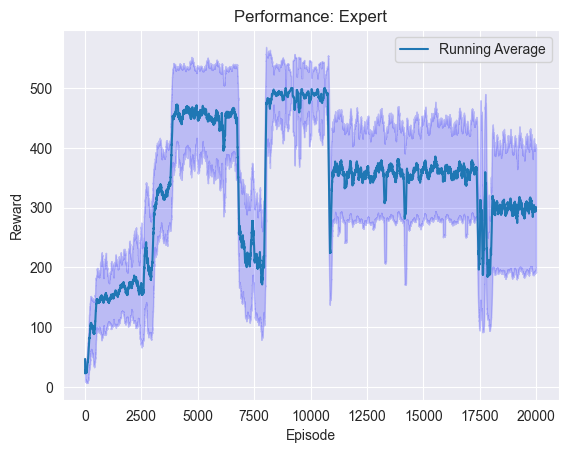

In [18]:
plot_running_avg_std(episode_rewards,title="Performance: Expert",save=True,name='Expert')

In [19]:
expertReward=play_policy(bins,expert_Q,N=10000,render=False)

[[1.820e+02 1.000e+00]
 [1.840e+02 2.000e+00]
 [1.850e+02 1.000e+00]
 [1.870e+02 4.000e+00]
 [1.890e+02 3.000e+00]
 [1.900e+02 1.000e+00]
 [1.910e+02 1.000e+00]
 [1.920e+02 3.000e+00]
 [1.930e+02 7.000e+00]
 [1.940e+02 5.000e+00]
 [1.950e+02 5.000e+00]
 [1.960e+02 1.200e+01]
 [1.970e+02 1.000e+01]
 [1.980e+02 2.000e+01]
 [1.990e+02 1.900e+01]
 [2.000e+02 1.900e+01]
 [2.010e+02 1.700e+01]
 [2.020e+02 2.400e+01]
 [2.030e+02 2.400e+01]
 [2.040e+02 3.300e+01]
 [2.050e+02 1.900e+01]
 [2.060e+02 3.800e+01]
 [2.070e+02 3.200e+01]
 [2.080e+02 3.400e+01]
 [2.090e+02 3.800e+01]
 [2.100e+02 4.500e+01]
 [2.110e+02 3.900e+01]
 [2.120e+02 5.000e+01]
 [2.130e+02 5.700e+01]
 [2.140e+02 6.700e+01]
 [2.150e+02 6.900e+01]
 [2.160e+02 7.100e+01]
 [2.170e+02 6.800e+01]
 [2.180e+02 7.800e+01]
 [2.190e+02 9.500e+01]
 [2.200e+02 9.600e+01]
 [2.210e+02 8.800e+01]
 [2.220e+02 9.400e+01]
 [2.230e+02 1.220e+02]
 [2.240e+02 1.050e+02]
 [2.250e+02 1.180e+02]
 [2.260e+02 9.900e+01]
 [2.270e+02 1.290e+02]
 [2.280e+02

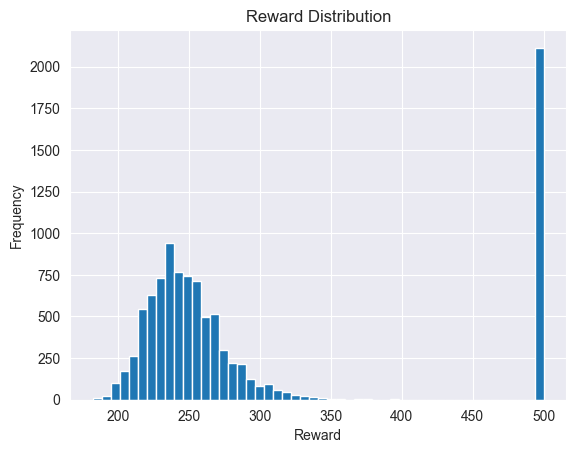

In [20]:
plt.hist(expertReward,bins=50)
plt.title("Reward Distribution")
plt.xlabel("Reward")
plt.ylabel("Frequency")
unique, counts = np.unique(expertReward, return_counts=True)
print (np.asarray((unique, counts)).T)

In [21]:
expertReward=play_policy(bins,expert_Q,N=1,render=True,delay=0.05)

/Users/fab/ET/Work/TA/HIAL/HIAL/.venv/lib/python3.13/site-packages/gymnasium/envs/classic_control/cartpole.py:215: UserWarning: WARN: You are calling render method without specifying any render mode. You can specify the render_mode at initialization, e.g. gym.make("CartPole-v1", render_mode="rgb_array")
  gym.logger.warn(


# **Inverse Reinforcement Learning**
* **Reward Function Replacement**: In the modified Q-learning algorithm, the standard reward signal returned by the environment is discarded. Instead, the algorithm utilizes a custom reward function $R(s,a)=w^T\phi(s)$. Here:
  * $w$ represents the weight vector learned through the IRL algorithm.
  * $\phi(s)$ denotes the observation features or state representation.
This adjustment allows the Q-learning agent to learn from the expert's behavior captured in the reward function learned through IRL.
* **Observation Features Normalization**: To ensure that observation features fall within the range $[0,1]$ for calculating feature expectations, each feature element is passed through a sigmoid function for mapping. The sigmoid function ensures that the output lies between 0 and 1, facilitating consistent feature scaling across different dimensions of the observation space.
$$y=\frac{1}{1+e^{-x}}$$

In [22]:
def sigmoid(arry: Union[float, np.ndarray]) -> Union[float, np.ndarray]:
  return 1 / (1 + np.exp(-arry))

# **IRL Algorithm Using Projection Method**

#### Input:
- Expert demonstrations: $\{(s_1, a_1), (s_2, a_2), ..., (s_N, a_N)\}$, where $s_i$ is the state and $a_i$ is the action taken by the expert in the demonstration.
- Feature function: $\phi: S \rightarrow \mathbb{R}^d$, which maps states to a feature space of dimension $d$.

#### Output:
- Learned reward function parameters: $w$


## Algorithm Steps:
1. **Initialization**: Start with an initial guess for the reward function parameters $w$.

2. **Feature Expectations Computation**:
   - For each state $s_i$ in the expert demonstrations:
     - Compute the feature vector $\phi(s_i)$.
     - Accumulate the feature expectation: $\hat{\mu} = \frac{1}{N} \sum_{i=1}^{N} \phi(s_i)$.

3. **Projection onto Feature Expectations**:
   - Solve the optimization problem to find the reward function parameters $w:
     w^* = \arg\min_w \| \hat{\mu} - \Phi w \|_2^2$
     where:
     - $\Phi$ is a matrix where each row is the feature vector $\phi(s_i)$.
     - $|\cdot\|_2$ denotes the Euclidean norm.

4. **Normalization**:
Normalize the learned reward function parameters \( w \) to ensure compatibility with the original feature space:
$ w \leftarrow \frac{w}{\| \hat{\mu} \|_2} $

5. **Termination Condition**:
   - Check for convergence criteria. If satisfied, terminate; otherwise, return to step $2$.

- **Objective**: The goal of the projection method is to find the reward function parameters $w$ that best match the observed feature expectations $\hat{\mu}$ of the expert demonstrations.
- **Feature Expectations**: The feature function $\phi$ is used to transform each state into a feature vector. The feature expectations are computed as the average of these feature vectors over all expert demonstrations.
- **Projection onto Feature Expectations**: The optimization problem aims to find the reward function parameters $w$ that minimize the squared Euclidean distance between the computed feature expectations and the feature expectations predicted by the reward function $\Phi w$.
- **Normalization**: Normalizing the learned reward function parameters helps ensure that the scale of $w$ matches the scale of the feature expectations $\hat{\mu}$, facilitating better convergence and stability.

In [23]:
def getFeatureExpectation(Q: Dict[str, Dict[int, float]], N: int = 1000) -> np.ndarray:
    observationSum=np.zeros(4)
    for i in range(N):
        observation, _ = env.reset()
        terminated = False
        truncated = False
        cnt=0
        while not (terminated or truncated):
            state = get_state_as_string(assign_bins(observation, bins))
            act = max_dict(Q[state])[0]
            observation, reward, terminated, truncated, info =env.step(act)
            observation=sigmoid(observation)
            observationSum+=(GAMMA**cnt)*observation
            cnt+=1
    featureExpectation=observationSum/N

    print("FeatureExpectation: ", featureExpectation)
    return featureExpectation

## **Question 2**
1. Fill in the blank spaces with your code to:
  - recover the reward function based on IRL
  - update the Q-table

In [24]:
def irl_play_one_game(bins: np.ndarray, weight: np.ndarray, Q: Dict[str, Dict[int, float]], eps: float = 0.5) -> Tuple[float, int]:
    observation, _ = env.reset()
    # done = False
    terminated = False
    truncated = False
    cnt = 0 # number of moves in an episode
    state = get_state_as_string(assign_bins(observation, bins))
    total_reward = 0


    while not (terminated or truncated):
        cnt += 1

        if np.random.uniform() < eps:
            act = env.action_space.sample() # epsilon greedy
        else:
            act = max_dict(Q[state])[0]

        observation, reward, terminated, truncated, info = env.step(act)

        #encode observations into state
        state_new = get_state_as_string(assign_bins(observation, bins))

        #map observations to 0 and 1
        observation=sigmoid(observation)

        #discard the simulation reward, and use the reward function found from irl algorithm
        ''' Add your code here '''
        reward = float(np.dot(weight, observation))

        total_reward += reward

        if (terminated or truncated) and cnt < 200:
            reward = -1


        a1, max_q_s1a1 = max_dict(Q[state_new])

        # update the Q-table
        ''' Add your code here '''
        Q[state][act] = Q[state][act] + ALPHA * (reward + GAMMA * max_q_s1a1 - Q[state][act])

        state, act = state_new, a1

    return total_reward, cnt

In [25]:
def irl_play_many_games(bins: np.ndarray, weight: np.ndarray, N: int = 10000) -> Tuple[List[int], List[float], Dict[str, Dict[int, float]]]:
    Q = initialize_Q()
    length = []
    reward = []
    for n in range(N):
        eps = 1.0 / np.sqrt(n+1)

        episode_reward, episode_length= irl_play_one_game(bins, weight,Q,eps)

        length.append(episode_length)
        reward.append(episode_reward)
    print("Avg Length %d"%(np.average(length)))
    print("standard deviation %d"%(np.std(length)))
    return length, reward, Q

In [26]:
expertExpectation=getFeatureExpectation(expert_Q,N=100000)

FeatureExpectation:  [3.07555772 1.94427732 3.24317031 4.76829307]


In [27]:
# either terminate with margin or iteration
epislon=0.00002
N=10

weight=[]
feature_expectation=[]
feature_expectation_bar=[]
learnedQ=[]
margin=[]
avgEpisodeLength=[]

for i in range(N):
    print("Iteration: ",i)
    if i==0: # step1, initialization
        initialQ=initialize_Q() # give random initial policy
        feature_expectation.append(getFeatureExpectation(initialQ))
        print("expert feature Expectation: ", expertExpectation)
        learnedQ.append(initialQ) # put in the initial policy
        weight.append(np.zeros(4)) # put in a dummy weight
        margin.append(1) # put in a dummy margin
    else: # first iter of step 2
        if i==1:
            feature_expectation_bar.append(feature_expectation[i-1])
            weight.append(expertExpectation-feature_expectation[i-1])
            margin.append(norm((expertExpectation-feature_expectation_bar[i-1]),2))

            print("margin: ",margin[i])
            print("weight: ",weight[i])

        else: # iter 2 and on of step 2
            A=feature_expectation_bar[i-2]
            B=feature_expectation[i-1]-A
            C=expertExpectation-feature_expectation_bar[i-2]
            feature_expectation_bar.append(A+(np.dot(B,C)/np.dot(B,B))*(B))

            weight.append(expertExpectation-feature_expectation_bar[i-1])
            margin.append(norm((expertExpectation-feature_expectation_bar[i-1]),2))

            print("margin: ",margin[i])
            print("weight: ",weight[i])

        # step3,terminate condition
        if (margin[i]<=epislon):
            break

        # step4
        episode_lengths, episode_rewards, learnedQ_i= irl_play_many_games(bins,weight[i])
        learnedQ.append(learnedQ_i)
        avgEpisodeLength.append(episode_lengths)
        # step5
        feature_expectation.append(getFeatureExpectation(learnedQ[i]))

    print("")

print("export trained IRL model...")
filename = 'learnedQ'
outfile = open(filename,'wb')
pickle.dump(learnedQ,outfile)
outfile.close()

Iteration:  0
FeatureExpectation:  [3.06315682 1.92266027 3.23232154 4.77204582]
expert feature Expectation:  [3.07555772 1.94427732 3.24317031 4.76829307]

Iteration:  1
margin:  0.027438260357799615
weight:  [ 0.0124009   0.02161705  0.01084877 -0.00375275]
Avg Length 134
standard deviation 34
FeatureExpectation:  [3.07310014 1.93731121 3.24163771 4.77347654]

Iteration:  2
margin:  0.006291500766570301
weight:  [-0.00083806  0.00211017 -0.00155517 -0.00565767]
Avg Length 239
standard deviation 161
FeatureExpectation:  [3.4409909  2.5337507  3.57076225 4.77791655]

Iteration:  3
margin:  0.006268418361535537
weight:  [-0.00109381  0.0016952  -0.00178387 -0.00566046]
Avg Length 238
standard deviation 157
FeatureExpectation:  [3.44406497 2.53986243 3.57253731 4.77818135]

Iteration:  4
margin:  0.006268417636955431
weight:  [-0.00109524  0.00169287 -0.00178515 -0.00566047]
Avg Length 236
standard deviation 143
FeatureExpectation:  [3.44270402 2.53964741 3.57017246 4.77817587]

Iteratio

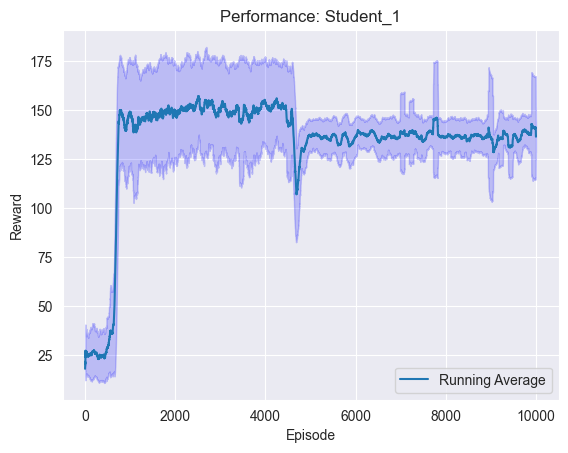

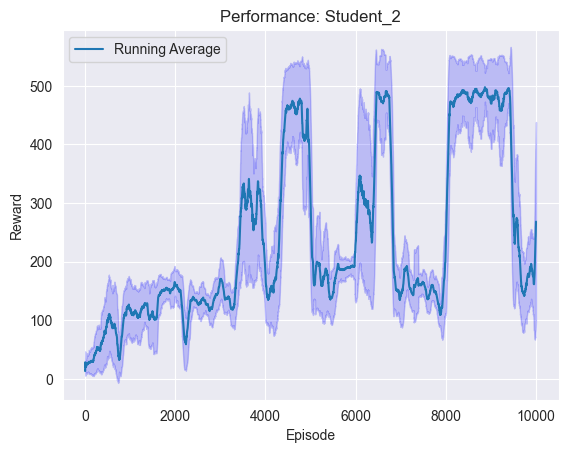

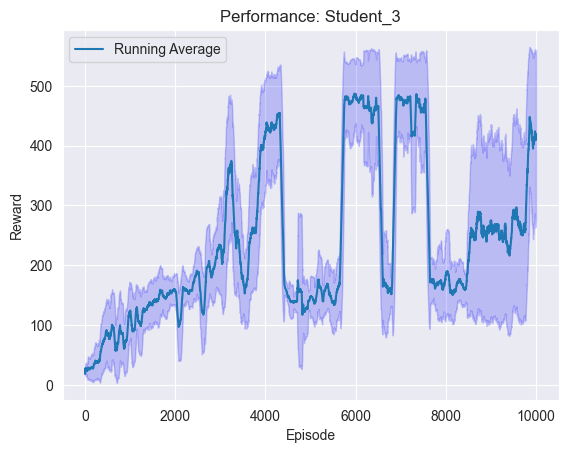

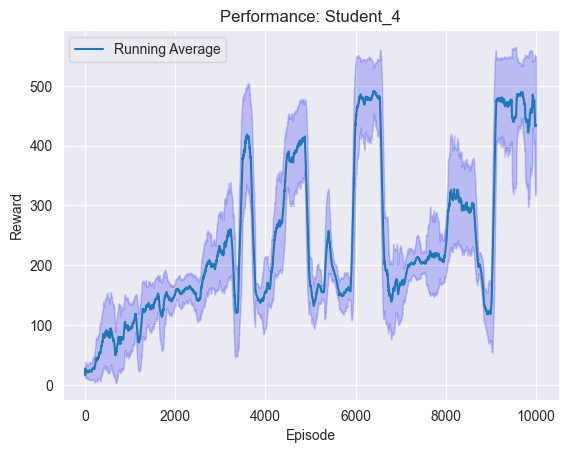

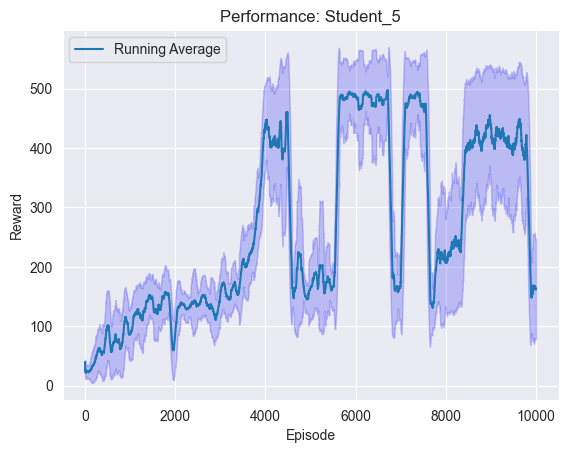

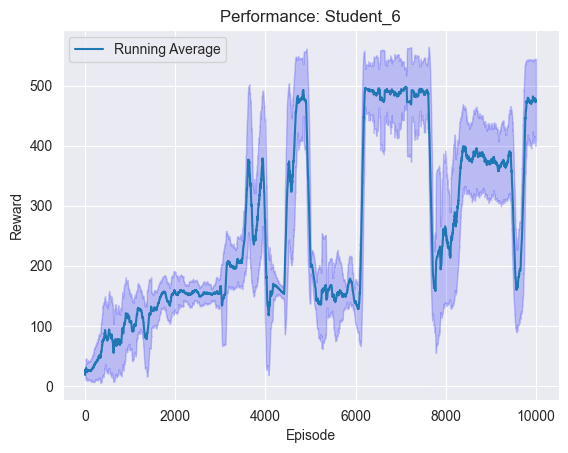

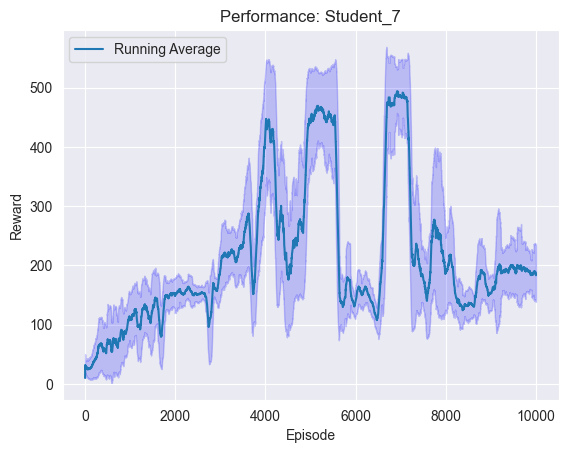

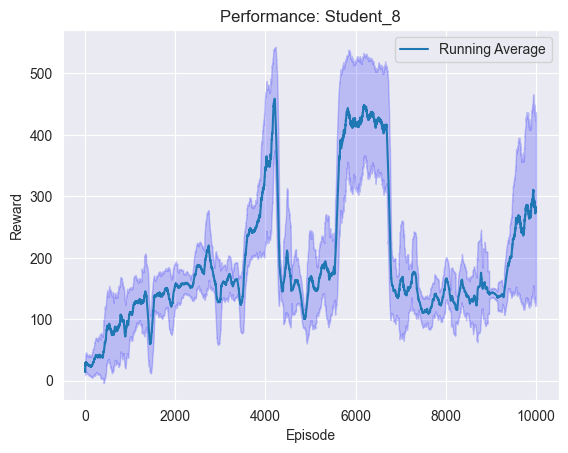

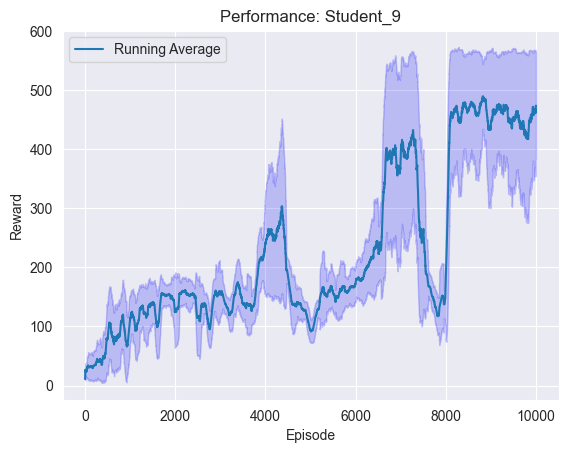

In [28]:
# showing the performance of each student
for i in range(0,len(avgEpisodeLength)):
    title="Performance: Student_"+str(i+1)
    plot_running_avg_std(avgEpisodeLength[i],title=title,save=True,name=title)

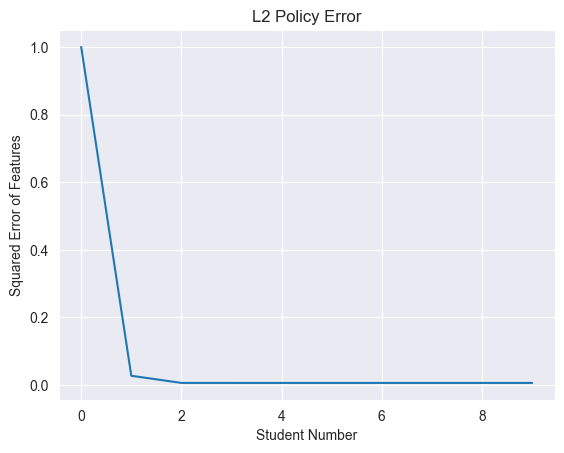

In [29]:
# Plotting Convergence Rate
plt.plot(margin)
plt.title("L2 Policy Error")
plt.xlabel("Student Number")
plt.ylabel("Squared Error of Features")
plt.savefig("policy_error")

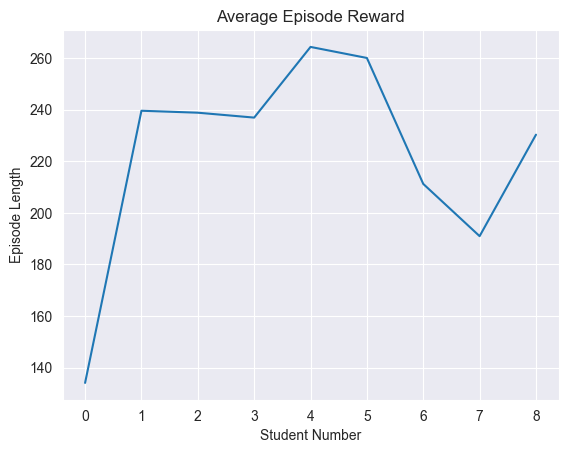

In [30]:
# showing the performance of each student relative to the performance of the expert
iteration=[]
relativePerformance=[]
studentPerformance=[]

for i in avgEpisodeLength:
    studentPerformance.append(np.average(i))

for i in range(np.size(studentPerformance)):
    iteration.append(i)
    relativePerformance.append(studentPerformance[i])

plt.plot(iteration,relativePerformance)
plt.xlabel("Student Number")
plt.ylabel("Episode Length")
plt.title("Average Episode Reward")
# plt.grid()
plt.savefig("studentRewards")

# **Maximum Conditional Entropy Inverse Reinforcement Learning**

In this tutorial we are exploring the **Cliffworld environment** (`CliffWorldEnv`), a partially observable Markov decision process (POMDP), to identify the optimal policy within a table-based setup that features a predefined reward function. To achieve this, we first solve for the optimal policy in the Cliffworld scenario. We then produce a series of demonstrations based on this optimal policy and apply Maximum Causal Entropy Inverse Reinforcement Learning (MCE IRL) to derive an approximation of the actual reward function. By having access to the true reward function in this example, we are able to perform a direct comparison between the learned reward and the ground-truth reward, enhancing our understanding of the effectiveness of our learning approach.

![cliffword](https://www.bpesquet.fr/mlkatas/_images/cliff_map.png)

In Cliffworld, the environment provides "observations" that include both partial direct observations and the full hidden state of the environment. To simplify the process of determining the optimal policy, we employ the `DictExtractWrapper` to isolate only the hidden states from these observations. This transformation effectively converts the environment from a partially observable to a fully observable Markov decision process (MDP), thereby facilitating the computation of the optimal policy. This approach not only simplifies the computational complexity but also allows us to focus on the efficiency of the learning algorithms in a controlled setting.

In [31]:
env_creator = partial(CliffWorldEnv, height=4, horizon=40, width=7, use_xy_obs=True)
env_single = env_creator()

state_env_creator = lambda: base_envs.ExposePOMDPStateWrapper(env_creator())

# This is just a vectorized environment because `generate_trajectories` expects one
state_venv = DummyVecEnv([state_env_creator] * 4)

Then we derive an expert policy using Bellman backups. We analytically compute the occupancy measures, and also sample some expert trajectories.

In [32]:
_, _, pi = mce_partition_fh(env_single)

_, om = mce_occupancy_measures(env_single, pi=pi)

rng = np.random.default_rng()
expert = TabularPolicy(
    state_space=env_single.state_space,
    action_space=env_single.action_space,
    pi=pi,
    rng=rng,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
    rng=rng,
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 128, 'return_min': 296.0, 'return_mean': 327.484375, 'return_std': 7.117303371429443, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


/Users/fab/ET/Work/TA/HIAL/HIAL/.venv/lib/python3.13/site-packages/imitation/data/types.py:279: UserWarning: tried to wrap <class 'numpy.int64'> as an observation
  warnings.warn(f"tried to wrap {type(obs)} as an observation")


# **Training the reward function**
The true reward here is not linear in the reduced feature space (i.e, coordinates). Finding an appropriate linear reward is impossible, but an MLP should Just Work.

In [33]:
def train_mce_irl(demos: Any, hidden_sizes: List[int], lr: float = 0.01, **kwargs: Any) -> Any:
    reward_net = reward_nets.BasicRewardNet(
        env_single.observation_space,
        env_single.action_space,
        hid_sizes=hidden_sizes,
        use_action=False,
        use_done=False,
        use_next_state=False,
    )

    mce_irl = MCEIRL(
        demos,
        env_single,
        reward_net,
        log_interval=250,
        optimizer_kwargs=dict(lr=lr),
        rng=rng,
    )
    occ_measure = mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
        rng=rng,
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(occ_measure)
    plt.title("Occupancy for learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    _, true_occ_measure = mce_occupancy_measures(env_single)
    env_single.draw_value_vec(true_occ_measure)
    plt.title("Occupancy for true reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(
        reward_net(th.as_tensor(env_single.observation_matrix), None, None, None)
        .detach()
        .numpy()
    )
    plt.title("Learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    env_single.draw_value_vec(env_single.reward_matrix)
    plt.title("True reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    return mce_irl

As you can see, a linear reward model cannot fit the data. Even though we're training the model on analytically computed occupancy measures for the optimal policy, the resulting reward and occupancy frequencies diverge sharply.

--------------------------
| grad_norm   | 31.4     |
| iteration   | 0        |
| linf_delta  | 34       |
| weight_norm | 0.508    |
--------------------------


/Users/fab/ET/Work/TA/HIAL/HIAL/.venv/lib/python3.13/site-packages/imitation/util/util.py:330: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:837.)
  norm_tensor = th.as_tensor(norms)


--------------------------
| grad_norm   | 4.59     |
| iteration   | 250      |
| linf_delta  | 20       |
| weight_norm | 2.11     |
--------------------------
--------------------------
| grad_norm   | 2.88     |
| iteration   | 500      |
| linf_delta  | 16.6     |
| weight_norm | 3.12     |
--------------------------
--------------------------
| grad_norm   | 2.2      |
| iteration   | 750      |
| linf_delta  | 14.8     |
| weight_norm | 3.84     |
--------------------------
Imitation stats:  {'n_traj': 128, 'return_min': -59.0, 'return_mean': 73.4453125, 'return_std': 45.103153228759766, 'return_max': 163.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


/Users/fab/ET/Work/TA/HIAL/HIAL/.venv/lib/python3.13/site-packages/imitation/data/types.py:279: UserWarning: tried to wrap <class 'numpy.int64'> as an observation
  warnings.warn(f"tried to wrap {type(obs)} as an observation")


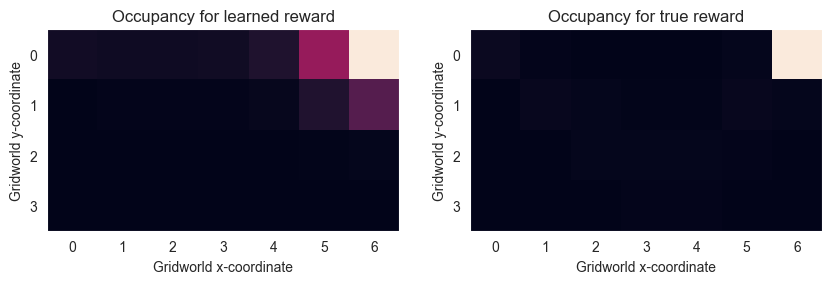

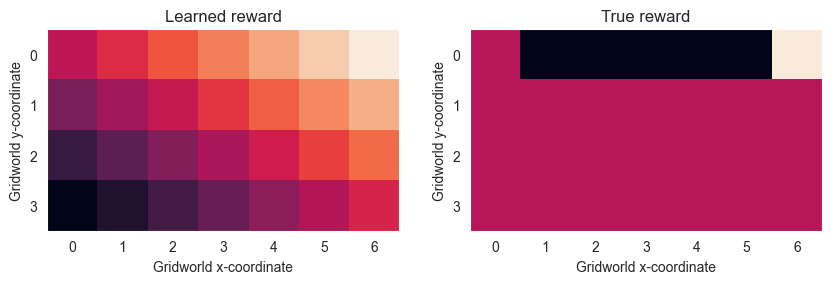

In [34]:
train_mce_irl(om, hidden_sizes=[])

Now, let's try using a very simple nonlinear reward model: an MLP with a single hidden layer. We first train it on the analytically computed occupancy measures. This should give a very precise result.

--------------------------
| grad_norm   | 132      |
| iteration   | 0        |
| linf_delta  | 33.9     |
| weight_norm | 11.4     |
--------------------------
--------------------------
| grad_norm   | 0.275    |
| iteration   | 250      |
| linf_delta  | 0.213    |
| weight_norm | 17.4     |
--------------------------
--------------------------
| grad_norm   | 0.269    |
| iteration   | 500      |
| linf_delta  | 0.15     |
| weight_norm | 19.2     |
--------------------------
--------------------------
| grad_norm   | 0.263    |
| iteration   | 750      |
| linf_delta  | 0.0885   |
| weight_norm | 21.4     |
--------------------------
Imitation stats:  {'n_traj': 128, 'return_min': 298.0, 'return_mean': 325.2109375, 'return_std': 9.472535133361816, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


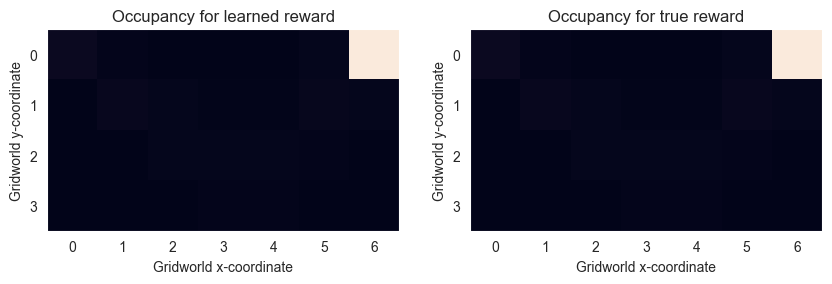

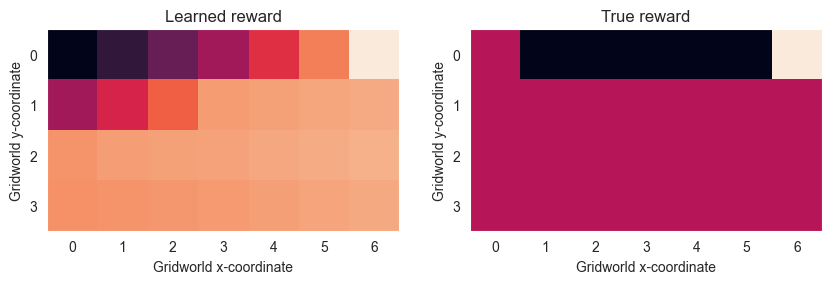

In [35]:
train_mce_irl(om, hidden_sizes=[256])

Then we train it on trajectories sampled from the expert. This gives a stochastic approximation to occupancy measure, so performance is a little worse. Using more expert trajectories should improve performance -- try it!

## **Question 3**
1. fill in the blank with your code to train an MCE-IRL model using both 10 expert demonstrations and an MLP with one hidden layer of 256 neurons.

In [37]:
expert_trajs[:10]

[TrajectoryWithRew(obs=array([ 0,  8, 16, 24, 18,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
         6,  6,  6,  6,  6,  6,  5]), acts=array([3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]), infos=array([{'old_state': np.int64(0), 'new_state': np.int64(8), 'TimeLimit.truncated': False},
        {'old_state': np.int64(8), 'new_state': np.int64(16), 'TimeLimit.truncated': False},
        {'old_state': np.int64(16), 'new_state': np.int64(24), 'TimeLimit.truncated': False},
        {'old_state': np.int64(24), 'new_state': np.int64(18), 'TimeLimit.truncated': False},
        {'old_state': np.int64(18), 'new_state': np.int64(5), 'TimeLimit.truncated': False},
        {'old_state': np.int64(5), 'new_state': np.int64(6), 'TimeLimit.truncated': False},
        {'old_state': np.int64(6), 'new_state': np.int64(6), 'TimeLimit.truncated':

In [39]:
len(expert_trajs)

128

--------------------------
| grad_norm   | 141      |
| iteration   | 0        |
| linf_delta  | 32.5     |
| weight_norm | 16.4     |
--------------------------
--------------------------
| grad_norm   | 0.973    |
| iteration   | 250      |
| linf_delta  | 0.224    |
| weight_norm | 26.7     |
--------------------------
--------------------------
| grad_norm   | 1.8      |
| iteration   | 500      |
| linf_delta  | 0.144    |
| weight_norm | 50.1     |
--------------------------
--------------------------
| grad_norm   | 3.79     |
| iteration   | 750      |
| linf_delta  | 0.135    |
| weight_norm | 99.5     |
--------------------------
Imitation stats:  {'n_traj': 128, 'return_min': 289.0, 'return_mean': 326.0234375, 'return_std': 8.983895301818848, 'return_max': 334.0, 'len_min': 40, 'len_mean': 40.0, 'len_std': 0.0, 'len_max': 40}


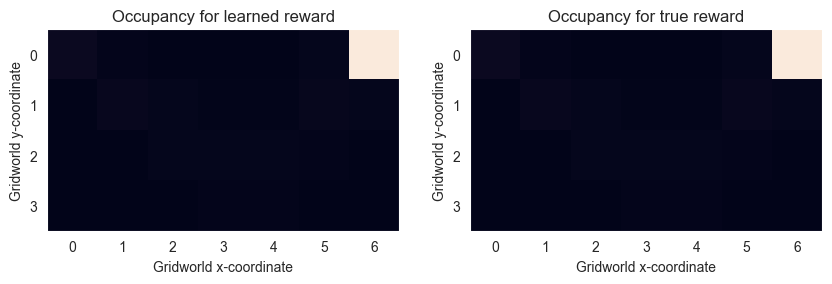

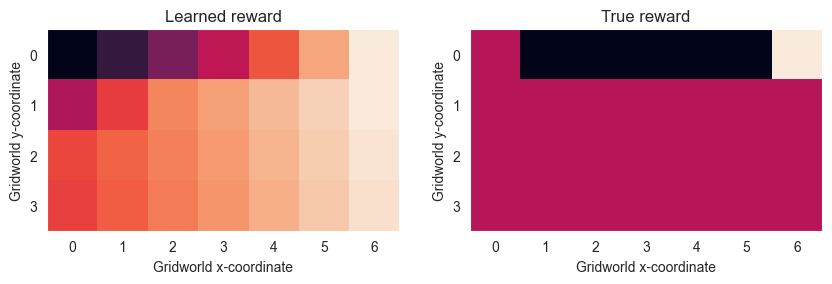

In [40]:
# use the first 10 demonstrations from the expert_trajs and a 256-sized hidden layer to train IRL
''' Add your code here '''
train_mce_irl(expert_trajs, hidden_sizes=[512])

## **Question 4**
1. With the extra expert trajectories, is the learned reward function more similar to the true reward function?
2. With the extra expert trajectories, is the occupancy measure more similar to the true one?
3. Explain why ending up in the cell that is just below the top rightmost one was considered almost as good as the top rightmost cell by the learned model

# **References**
* Abbeel, P., & Ng, A. Y. (2004, July). Apprenticeship learning via inverse reinforcement learning. In Proceedings of the twenty-first international conference on Machine learning (p. 1).
* Ziebart, B. D., Maas, A. L., Bagnell, J. A., & Dey, A. K. (2008, July). Maximum entropy inverse reinforcement learning. In Aaai (Vol. 8, pp. 1433-1438).